Zadanie 02 - Główne składowe odzieży

Piotr Zawiślan

Celem zadania będzie przetestowanie poznanej techniki PCA w kontakcie z prawdziwymi danymi.

In [1]:
import sys
import os
import numpy as np
import sklearn
import pandas as pd
import PIL
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

from typing import Tuple, Dict
%matplotlib inline

In [2]:
np.random.seed(311)

PLOTS_PATH = os.path.join(".", "plots")
os.makedirs(PLOTS_PATH, exist_ok=True)

In [3]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(PLOTS_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
def plot_image_greyscale(image: np.ndarray, title=None, fig_id=None):
    if type(image) is np.ndarray:
        image /= np.max(image)
    plt.figure(figsize=(4, 6))
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.imshow(image, cmap="Greys")
    if fig_id is not None:
        save_fig(fig_id)
    plt.show()

# Dane do wykorzystania

Do realizacji zadania potrzebny będzie nam niewielki zbiór z fotografiami. Co prawda fotografie
nie są danymi czysto wektorowymi (i ich praktyczne przetwarzanie wymaga brania pod uwagę
również informacji o wzajemnym położeniu poszczególnych pikseli) - ale za to łatwo je
interpretować metodą "na oko" i pozwalają na uzyskiwanie atrakcyjnych wizualnie rezultatów.
Przy tworzeniu zbioru można współpracować z innymi studentami z kursu, ale w grupach po kilka
osób (e.g. nie jest tak, że cały rocznik korzysta z pracy jednej osoby ;]).

Potrzebujemy zgromadzić zbiór zawierający 3 rodzaje różnych (ale nie diametralnie różnych)
obiektów i zawierający przynajmniej po kilkanaście (lub więcej) przykładów każdego z nich (np. 3
typy zawartości i 20 zdjęć każdego z nich, łącznie 60 zdjęć). Postarajmy się też, by obiekty były
wycentrowane oraz zaprezentowane na jednolitym tle i w podobnym oświetleniu. Co się nadaje?

- Trzy typy ubrań (np. koszule, t-shirty i marynarki) z katalogu ulubionej marki odzieżowej
(prezentowane w tej samej pozie - albo po prostu bez modela).
     - Osoby potrzebujące oszczędzić na czasie mogą wykorzystać wybrane 3 klasy ze zbioru FashionMNIST ( https://github.com/zalandoresearch/fashion-mnist ). Wyniki będą mniej ciekawe (i realistyczne), bo FashionMNIST zawiera fotografie o niskiej rozdzielczości, za to perfekcyjnie przebrane i wycentrowane. Czyli dokładnie odwrotnie niż zwykle się zdarza. ;]

- Trzy rodzaje butów (np. sandały, trampki, trapery) z katalogów obuwniczych - tak jak w
poprzednim punkcie, staramy się skorzystać z ujęć robionych pod tym samym kątem.

- Trzy rodzaje naczyń (np. kubki, szklanki, kieliszki) z katalogów odpowiedniego sklepu.

- Trzy rodzaje sztućców (np. łyżki, noże i widelce).

- Wygenerowane twarze trzech typów postaci (np. stereotypowy człek, elf i krzat) w grze komputerowej pozwalające na losowe generowanie wyglądu bohaterów.
    - Zadanie miało być pierwotnie oparte o właśnie taki zbiór, ale nie znalazłem darmowej gry o niskich wymogach sprzętowych i satysfakcjonującej jakości generatora.

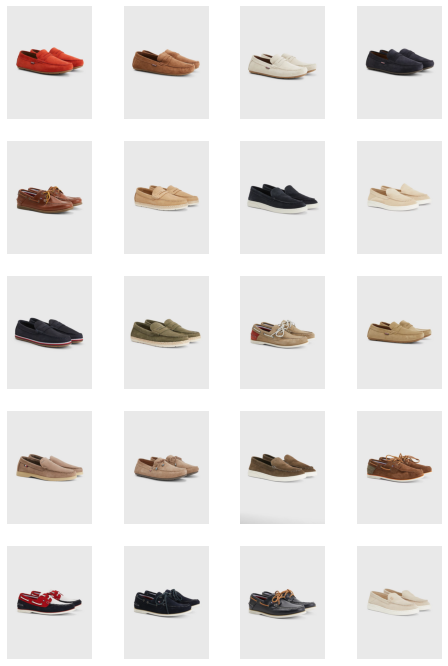

In [5]:
# Zbiór danych: 3 rodzaje butów marki Tommy Hilfiger: mokasyny, adidasy, tenisówki
plt.figure(figsize=(8, 12))
directory = "./data/loafers/"
for i, filename in enumerate(os.listdir(directory)):
    f_path = os.path.join(directory, filename)
    if os.path.isfile(f_path):
        with PIL.Image.open(f_path) as im:
            plt.subplot(5, 4, i+1)
            plt.axis('off')
            plt.imshow(im)
plt.show()

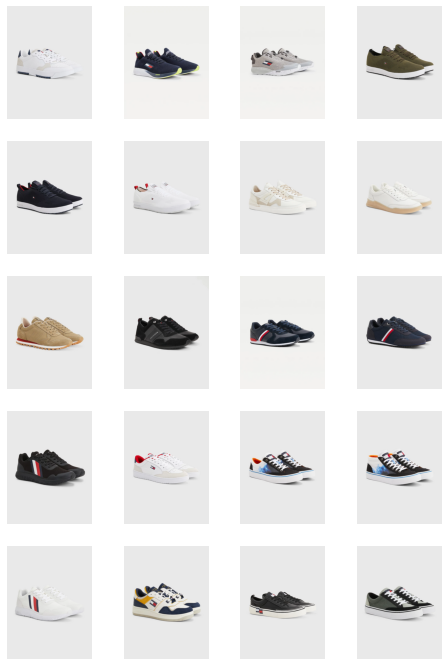

In [6]:
plt.figure(figsize=(8, 12))
directory = "./data/sneakers/"
for i, filename in enumerate(os.listdir(directory)):
    f_path = os.path.join(directory, filename)
    if os.path.isfile(f_path):
        with PIL.Image.open(f_path) as im:
            plt.subplot(5, 4, i+1)
            plt.axis('off')
            plt.imshow(im)
plt.show()

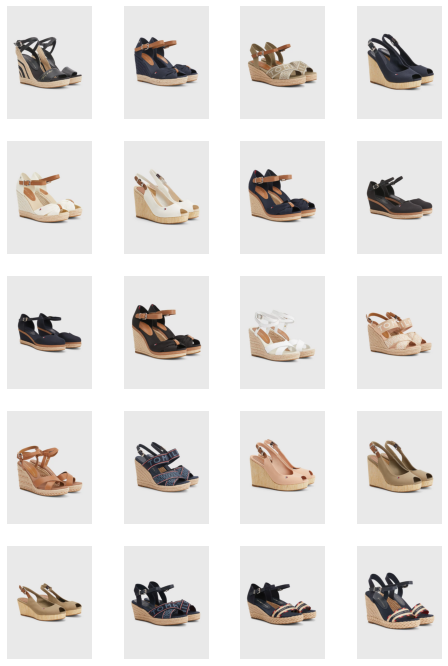

In [7]:
plt.figure(figsize=(8, 12))
directory = "./data/wedges/"
for i, filename in enumerate(os.listdir(directory)):
    f_path = os.path.join(directory, filename)
    if os.path.isfile(f_path):
        with PIL.Image.open(f_path) as im:
            plt.subplot(5, 4, i+1)
            plt.axis('off')
            plt.imshow(im)
plt.show()

In [8]:
N_SAMPLES = 60

In [9]:
shoes_list = []
directories = ["./data/loafers/", "./data/sneakers/", "./data/wedges/"]
for directory in directories:
    for filename in os.listdir(directory):
        f_path = os.path.join(directory, filename)
        if os.path.isfile(f_path):
            shoes_list.append(PIL.Image.open(f_path))
                
assert len(shoes_list) == N_SAMPLES

In [10]:
print(shoes_list[0].size)
np.all(np.array([shoe_im.size == (682, 910) for shoe_im in shoes_list], dtype=bool))

(682, 910)


True

# Wstępna obróbka

Po zgromadzeniu odpowiedniej liczby zdjęć przygotowujemy je do późniejszego użycia. W tym
celu można użyć np. 
- biblioteki Pillow ( https://pillow.readthedocs.io - do pracy z obrazami) 
- biblioteki numpy ( https://note.nkmk.me/en/python-numpy-image-processing - do pracy z macierzami i wektorami) - lub dowolnego innego preferowanego narzędzia.

- By przyśpieszyć późniejsze obliczenia zmniejszamy rozdzielczość fotografii (np. do rozmiaru 100x100) - ale z zachowaniem sensownych proporcji (nie muszą być to same kwadraty).

- Ważne natomiast jest to, by na koniec każda fotografia miała ten sam rozmiar.

- Konwertujemy je do skali szarości.

In [11]:
im_width, im_height = shoes_list[0].width // 8, shoes_list[0].height // 8
shoe_list_converted = []
for shoe_im in shoes_list:
    shoe_list_converted.append(shoe_im.resize((im_width, im_height)).convert('L'))

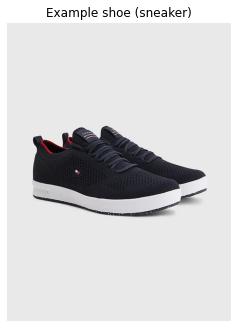

In [12]:
plt.figure(figsize=(4, 6))
plt.axis('off')
plt.imshow(shoes_list[24])
plt.title("Example shoe (sneaker)")
plt.show()

Saving figure transformed_example_shoe


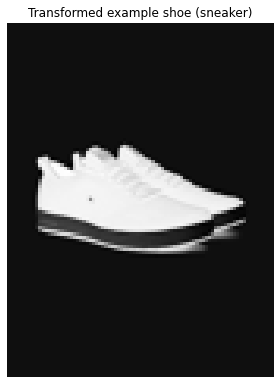

In [13]:
plot_image_greyscale(shoe_list_converted[24], 
                     "Transformed example shoe (sneaker)", 
                     "transformed_example_shoe")

In [14]:
print(f"Image size = {im_width, im_height}")
print(f"Vector length = {im_width * im_height}")

Image size = (85, 113)
Vector length = 9605


- Zamieniamy obrazy (tablice dwuwymiarowe, *de facto* macierze) na wektory poprzez
odczytanie kolejno wartości poszczególnych pikseli (wtedy np. fotografia 120x80 pikseli staje
się wektorem 9600-wymiarowym). Każdy taki wektor będzie stanowił jedną obserwację.

In [15]:
shoes_arr = np.empty((N_SAMPLES, im_width * im_height))
for i, shoe_im in enumerate(shoe_list_converted):
    shoes_arr[i] = np.array(shoe_im, dtype=np.uint8).flatten()

In [16]:
print(shoes_arr.shape)

(60, 9605)


# No dobra, pora się wreszcie pobawić PCA

Przechodzimy teraz do części właściwej zadania. Na tak przygotowanym zbiorze danych
wykonujemy transformację PCA, wcześniej go oczywiście centrując (gotowa implementacja np.
tutaj https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html ).
Następnie staramy się odpowiedzieć na poniższe pytania (czasem może być potrzebne
sporządzenie wykresu lub niewielkiej wizualizacji).

- Jak wyglądała dla tego zbioru macierz kowariancji przed transformacją PCA? Jak po jej wykonaniu?

In [17]:
mean_shoe_im = shoes_arr.mean(axis=0)
mean_loafer_im = shoes_arr[:20].mean(axis=0)
mean_sneaker_im = shoes_arr[20:40].mean(axis=0)
mean_weadge_im = shoes_arr[40:].mean(axis=0)

In [18]:
shoes_arr_centered = shoes_arr - mean_shoe_im

In [19]:
from sklearn.decomposition import PCA
shoe_pca = PCA(svd_solver='full')
shoes_arr_tranformed = shoe_pca.fit_transform(shoes_arr)

In [20]:
print(f"Original shape: {shoes_arr.shape}")
print(f"Transformed shape: {shoes_arr_tranformed.shape}")

Original shape: (60, 9605)
Transformed shape: (60, 60)


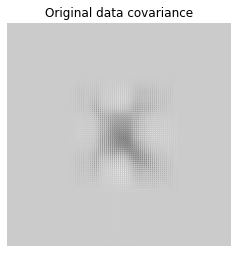

(9605, 9605)


In [21]:
plot_image_greyscale(np.cov(shoes_arr_centered.T), "Original data covariance")
print(np.cov(shoes_arr_centered.T).shape)

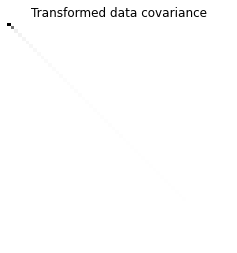

(60, 60)


In [22]:
plot_image_greyscale(np.cov(shoes_arr_tranformed.T), "Transformed data covariance")
print(np.cov(shoes_arr_tranformed.T).shape)

- Jak rozkładały się wariancje poszczególnych cech przed transformacją PCA? A jak po jej
użyciu?

In [23]:
# Przed
original_vars = np.diag(np.cov(shoes_arr_centered.T))

In [ ]:
plt.bar(height=original_vars, x=np.arange(im_height*im_width), color="b")
plt.title("Variances of original data")
plt.xlabel("Feature (pixel)")
plt.ylabel("Variance")
plt.grid()
plt.show()

In [ ]:
transformed_vars = np.diag(np.cov(shoes_arr_tranformed.T))

In [ ]:
plt.bar(height=transformed_vars, x=np.arange(60), color="r")
plt.title("Variances of transformed data")
plt.xlabel("Principal component")
plt.ylabel("Variance")
plt.grid()
plt.show()

- Jak wyglądało średnie zdjęcie (to które odjęliśmy od pozostałych, by wycentrować zbiór)?
    - Do realizacji tego i kilku kolejnych punktów przyda się funkcja, która wykona operację odwrotną do wektoryzacji - czyli zamieni wektor (w tym przypadku zawierający średnie wartości poszczególnych cech) na fotografię.

In [ ]:
plot_image_greyscale(mean_shoe_im.reshape(im_height, im_width), 
                     "Mean shoe", 
                     "mean_shoe")

In [ ]:
plot_image_greyscale(mean_loafer_im.reshape(im_height, im_width),
                     "Mean loafer", 
                     "mean_loafer")

In [ ]:
plot_image_greyscale(mean_sneaker_im.reshape(im_height, im_width), 
                     "Mean sneaker",
                     "mean_sneaker")

In [ ]:
plot_image_greyscale(mean_weadge_im.reshape(im_height, im_width), 
                     "Mean wedge",
                     "mean_wedge")

- Jak wyglądają znalezione nowe wektory bazowe (czyli główne składowe – *principal components*) Zaprezentuj je posortowane według powiązanej wariancji.
    - Zauważmy, że wektory bazowe też są wektorami z oryginalnej przestrzeni. A że oryginalna przestrzeń zawierała fotografie, to znalezioną "lepszą" bazę możemy również zwizualizować w postaci obrazów, tak jak średnią fotografię z poprzedniego punktu.

In [ ]:
shoe_pca.components_.shape   # sorted by explained_variance_

In [ ]:
plot_image_greyscale(shoe_pca.components_[0].reshape((im_height, im_width)), 
                     "First principal component",
                     "1st_pc")

In [ ]:
plot_image_greyscale(shoe_pca.components_[1].reshape((im_height, im_width)),
                     "Second principal component",
                     "2nd_pc")

In [ ]:
plot_image_greyscale(shoe_pca.components_[2].reshape((im_height, im_width)), 
                     "Third principal component",
                     "3rd_pc")

In [ ]:
plot_image_greyscale(shoe_pca.components_[3].reshape((im_height, im_width)), 
                     "Fourth principal component",
                     "4th_pc")

In [ ]:
plot_image_greyscale(shoe_pca.components_[4].reshape((im_height, im_width)), 
                     "Fifth principal component",
                     "5th_pc")

In [ ]:
plot_image_greyscale(shoe_pca.components_[5].reshape((im_height, im_width)), 
                     "Sixth principal component",
                     "6th_pc")

In [ ]:
plot_image_greyscale(shoe_pca.components_[6].reshape((im_height, im_width)), 
                     "Seventh principal component",
                     "7th_pc")

In [ ]:
plot_image_greyscale(shoe_pca.components_[7].reshape((im_height, im_width)), 
                     "Eighth principal component",
                     "8th_pc")

In [ ]:
plot_image_greyscale(shoe_pca.components_[8].reshape((im_height, im_width)), 
                     "Ninth principal component",
                     "9th_pc")

- Zredukujmy wymiarowość naszych obserwacji do odpowiednio 3, 9 i 27 najważniejszych cech. Jak wyglądają tak "odchudzone" z wymiarów fotografie? Żeby odpowiedzieć na to pytanie wykonaj poniższe kroki.
    - Wyzerujmy wartości wszystkich cech poza tą wybraną garstką.
    - Przetransformujmy tak zmodyfikowane obserwacje ponownie do oryginalnej bazy (może być konieczne użycie odwrotności macierzy przejścia lub odpowiedniej metody z bibliotecznej implementacji).
    - Dodajmy do każdej z nich średni wektor (odwracając wycentrowanie).
    - Przekształćmy wektor ponownie do kształtu fotografii i wyświetlmy.
    - W praktyce wygląda to tak: robimy PCA (konwersja: fotografia → wektor cech w nowej bazie), usuwamy zbędne cechy (zerując pozostałe), robimy odwrotność PCA (konwersja: zmodyfikowany wektor cech w nowej bazie → fotografia).

In [ ]:
# Plot original example shoes

In [ ]:
plot_image_greyscale(shoes_arr[0].reshape((im_height, im_width)),
                     "Example shoe A - original",
                     "ex_shoe_A_original")

In [ ]:
plot_image_greyscale(shoes_arr[30].reshape((im_height, im_width)),
                     "Example shoe B - original",
                     "ex_shoe_B_original")

In [ ]:
plot_image_greyscale(shoes_arr[50].reshape((im_height, im_width)),
                     "Example shoe C - original",
                     "ex_shoe_C_original")

In [ ]:
shoe_pca_3 = PCA(n_components=3, svd_solver='full')
shoes_arr_tranformed_3 = shoe_pca_3.fit_transform(shoes_arr_centered)
shoes_arr_retrieved_3 = shoe_pca_3.inverse_transform(shoes_arr_tranformed_3)

In [ ]:
# plot retrieved from pca(n_comp=3) example shoes

In [ ]:
plot_image_greyscale(shoes_arr_retrieved_3[0].reshape((im_height, im_width)) + \
                     mean_shoe_im.reshape(im_height, im_width), 
                     "Example shoe A - reduced to 3 PC",
                     "ex_shoe_A_pca3")

In [ ]:
plot_image_greyscale(shoes_arr_retrieved_3[30].reshape((im_height, im_width)) + \
                     mean_shoe_im.reshape(im_height, im_width), 
                     "Example shoe B - reduced to 3 PC",
                     "ex_shoe_B_pca3")

In [ ]:
np.allclose(shoes_arr_retrieved_3[30], shoes_arr_retrieved_3[0])

In [ ]:
plot_image_greyscale(shoes_arr_retrieved_3[50].reshape((im_height, im_width)) + \
                     mean_shoe_im.reshape(im_height, im_width), 
                     "Example shoe C - reduced to 3 PC",
                     "ex_shoe_C_pca3")

In [ ]:
# plot retrieved from pca(n_comp=9) example shoes

In [ ]:
shoe_pca_9 = PCA(n_components=9, svd_solver='full')
shoes_arr_tranformed_9 = shoe_pca_9.fit_transform(shoes_arr_centered)
shoes_arr_retrieved_9 = shoe_pca_9.inverse_transform(shoes_arr_tranformed_9)

In [ ]:
plot_image_greyscale(shoes_arr_retrieved_9[0].reshape((im_height, im_width)) + \
                     mean_shoe_im.reshape(im_height, im_width), 
                     "Example shoe A - reduced to 9 PC",
                     "ex_shoe_A_pca9")

In [ ]:
plot_image_greyscale(shoes_arr_retrieved_9[30].reshape((im_height, im_width)) + \
                     mean_shoe_im.reshape(im_height, im_width),
                     "Example shoe B - reduced to 9 PC",
                     "ex_shoe_B_pca9")

In [ ]:
plot_image_greyscale(shoes_arr_retrieved_9[50].reshape((im_height, im_width)) + \
                     mean_shoe_im.reshape(im_height, im_width), 
                     "Example shoe C - reduced to 9 PC",
                     "ex_shoe_C_pca9")

In [ ]:
# plot retrieved from pca(n_comp=27) example shoes

In [ ]:
shoe_pca_27 = PCA(n_components=27, svd_solver='full')
shoes_arr_tranformed_27 = shoe_pca_27.fit_transform(shoes_arr_centered)
shoes_arr_retrieved_27 = shoe_pca_27.inverse_transform(shoes_arr_tranformed_27)

In [ ]:
plot_image_greyscale(shoes_arr_retrieved_27[0].reshape((im_height, im_width)) + \
                     mean_shoe_im.reshape(im_height, im_width),
                     "Example shoe A - reduced to 27 PC",
                     "ex_shoe_A_pca27")

In [ ]:
plot_image_greyscale(shoes_arr_retrieved_27[30].reshape((im_height, im_width)) + \
                     mean_shoe_im.reshape(im_height, im_width),
                     "Example shoe B - reduced to 27 PC",
                     "ex_shoe_B_pca27")

In [ ]:
plot_image_greyscale(shoes_arr_retrieved_27[50].reshape((im_height, im_width)) + \
                     mean_shoe_im.reshape(im_height, im_width), 
                     "Example shoe C - reduced to 27 PC",
                     "ex_shoe_C_pca27")

- Na koniec użyjmy PCA do zrzutowania naszego zbioru na płaszczyznę 2D. Jak wygląda taka wizualizacja? Tym razem trzeba będzie wykonać nieco inne kroki.
    - Zredukujmy wymiarowość do 2 najważniejszych aspektów danych. Nie zerujmy odrzucanych cech, a po prostu odpowiednio skróćmy wektory (obserwacje powinny stać się wektorami dwuwymiarowymi).
    - Użyjmy tych wektorów 2D jako współrzędnych na płaszczyźnie. Dla każdej z obserwacji namalujmy w tym miejscu kropkę. Uzależnijmy kolor danej kropki od typu obiektu, który reprezentowała obserwacja (np. spódnica → niebieska kropka, sukienka → czerwona kropka, etc.).
        - Alternatywnie (jeżeli umiemy sprawnie operować biblioteką do tworzenia wykresów) możemy umieścić na tych współrzędnych nie kropkę, a niewielką miniaturkę oryginalnej fotografii. ;]

In [ ]:
shoe_pca_2 = PCA(n_components=2, svd_solver="full")
shoes_arr_tranformed_2 = shoe_pca_2.fit_transform(shoes_arr_centered)

In [ ]:
shoes_arr_tranformed_2_normalized = \
    sklearn.preprocessing.MinMaxScaler().fit_transform(shoes_arr_tranformed_2)

plt.figure(figsize=(13,10))
shoe_types = np.zeros(60, dtype=int)
shoe_types[20:40] = 1
shoe_types[40:] = 2
plt.scatter(shoes_arr_tranformed_2_normalized[:, 0], 
            shoes_arr_tranformed_2_normalized[:, 1], 
            c=shoe_types, cmap="jet")
plt.colorbar()
plt.title("Shoes in 2d space (values normalized)")
plt.xlabel("1st PC axis")
plt.ylabel("2st PC axis")
save_fig("shoes_2d_dots")
plt.show()

In [ ]:
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_shoes_2d(X, y, 
                figsize=(13, 10), 
                title=None, 
                thumbnails=None, 
                thumbnail_sel_list=(0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55),
                fig_id=None):
    X_normalized = sklearn.preprocessing.MinMaxScaler().fit_transform(X)
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 3)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        if index in thumbnail_sel_list:
            image = thumbnails[index]
            imagebox = AnnotationBbox(OffsetImage(image), 
                                      image_coord)
            ax.add_artist(imagebox)
    if fig_id is not None:
        save_fig(fig_id)
    if title is not None:
        plt.title(title)
    plt.show()

In [ ]:
th_width, th_height = im_width // 2, im_height // 2
print(f"Thumbnail size: {(th_width, th_height)}")
shoes_thumbnails = [shoe_im.resize((th_width, th_height)) for shoe_im in shoes_list]

In [ ]:
plot_shoes_2d(shoes_arr_tranformed_2,
              shoe_types,
              thumbnails=shoes_thumbnails,
              figsize=(13, 10),
              title="Shoes in 2d with thumbnails",
              thumbnail_sel_list=tuple(range(60)),
             fig_id="shoes_2d_thumb_all")

In [ ]:
sel_list = [1, 2, 7, 12, 17, 21, 24, 39, 40, 41, 42, 43, 45, 47, 48, 49]

In [ ]:
plot_shoes_2d(shoes_arr_tranformed_2,
              shoe_types,
              thumbnails=shoes_thumbnails,
              figsize=(13, 10),
              title="Shoes in 2d with selected thumbnails",
              thumbnail_sel_list=tuple(sel_list),
             fig_id="shoes_2d_thumb_sel")